In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import pandas as pd
import numpy as np

In [6]:
dataset=pd.read_csv('/content/housing.csv')
print("First ten rows:")
dataset.head(10)


First ten rows:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4654785390>,
      dtype=object)

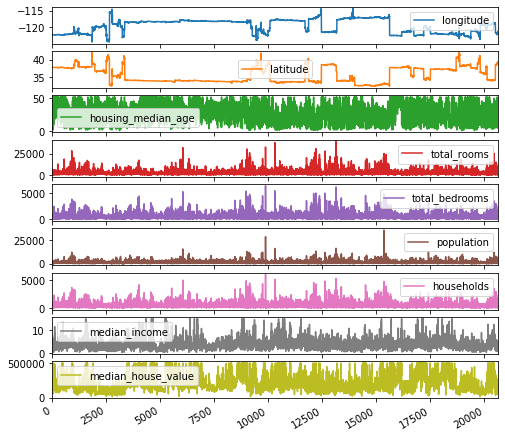

In [7]:
import matplotlib.pyplot as plt

dataset.plot(subplots=True, figsize=(8,8))

In [0]:
Y = dataset['median_house_value']
X = dataset.loc[:,'longitude':'median_income']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=2003)
print("There are " + str(x_train.size) + " training entries and " + str(x_test.size) + " testing entries")

There are 115584 training entries and 49536 testing entries


In [0]:
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size,inputs, outputs):
    super(CnnRegressor,self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.output = outputs
    self.input_layer = Conv1d(inputs, batch_size,1)
    self.max_poolong_layer = MaxPool1d(1)
    self.conv_layer = Conv1d(batch_size,128,1)
    self.flatten_layer = Flatten()
    self.linear_layer = Linear(128,64)
    self.output_layer = Linear(64, outputs)

  def feed(self, input):
    input = input.reshape((self.batch_size,self.inputs,1))
    output = relu(self.input_layer(input))
    output = self.max_poolong_layer(output)
    output = relu(self.conv_layer(output))
    output = self.flatten_layer(output)
    output = self.linear_layer(output)
    output = self.output_layer(output)
    return output

In [21]:
from torch.optim import SGD
from torch.optim import Adadelta
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [22]:
batch_size = 64
model = CnnRegressor(batch_size, X.shape[1], 1)
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_poolong_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss=0
  avg_score = 0
  count = 0
  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions, output)
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    avg_loss += loss.item()
    avg_score += score
    count += 1

  return avg_loss / count, avg_score / count

In [25]:
epochs = 100
##optimizer = SGD(model.parameters(), lr=1e-5)
optimizer= Adadelta(model.parameters(), lr=1.0, rho=0.4, eps=1e-06, weight_decay=0)
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
xx = 0
yy = 0
for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)
  if avg_r2_score > xx:
    xx = avg_r2_score
    yy = epochs 
print(" Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss)+ "\n\t R^2 Score = " +str(avg_r2_score))

 Epoch 100:
	Loss = 88036.76243055555
	 R^2 Score = -0.05684351176504671


In [26]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))

The model's L1 loss is: 89107.32763671875
The model's R^2 score is: -0.053361232834572815
